In [1]:
from langchain.chat_models import ChatOpenAI
from langchain.chains import LLMChain, RetrievalQA
from langchain.prompts import PromptTemplate
from langchain.vectorstores import Chroma
from langchain.embeddings import OpenAIEmbeddings
from langchain.schema import Document as langDocument
from langchain.text_splitter import NLTKTextSplitter
from docx import Document as DocxDocument

import json
import re
from typing import Literal
from langchain.chat_models import ChatOpenAI
from langchain.chains import LLMChain, RetrievalQA
from langchain.prompts import PromptTemplate

import re
import numpy as np
import pandas as pd


from score_fcm import ScoreCalculator
import gc


import demjson3

In [2]:
import os
import pypandoc
from docx import Document

def read_all_text_files(folder_path):
    contents = []

    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)

        if filename.endswith('.txt'):
            with open(file_path, 'r', encoding='utf-8') as f:
                contents.append(f.read())

        elif filename.endswith('.docx'):
            doc = DocxDocument(file_path)
            text = "\n".join([para.text for para in doc.paragraphs])
            contents.append(text)

        elif filename.endswith('.doc'):
            try:
                # Convert .doc to plain text using pandoc
                text = pypandoc.convert_file(file_path, 'plain')
                contents.append(text)
            except Exception as e:
                print(f"❌ Could not read {filename}: {e}")

    return "\n\n\n\n\n\n\n\n\n".join(contents)

In [3]:
basic = """You are helping build a fuzzy cognitive map (FCM) from an interview document.

### TASK ###
Extract all **causal relationships** between unique concepts from the interview segment below. Use context-level context to provide direct **evidence** for each causal relationship.

### INSTRUCTIONS ###
1. Identify concepts that can increase or decrease.
   - Avoid directional language in concept names (e.g., "increase", "decline").
   - Be specific to the terms used, do not generalize

2. Make sure evidence is correctly quoted to avoid invalid json. if there are quotes in the evidence handle them appropriately.

Output causal relationships in this format:
```json
[
  {{
    "src": "<SOURCE CONCEPT>",
    "dir": "INCREASES" | "DECREASES",
    "tgt": "<TARGET CONCEPT>"
  }},
  ...
]

**Interview Segment**
{question}
"""

agent1_template = """You are helping build a fuzzy cognitive map (FCM) from an interview document.

### TASK ###
Extract all **causal relationships** between unique concepts from the interview segment below. Use context to provide direct **evidence** for each causal relationship.

### INSTRUCTIONS ###
1. Identify concepts that can increase or decrease.
   - Avoid directional language in concept names (e.g., "increase", "decline").
   - Be specific to the terms used, do not generalize

2. Make sure evidence is correctly quoted to avoid invalid json. if there are quotes in the evidence handle them appropriately.

Output causal relationships in this format:
```json
[
  {{
    "src": "<SOURCE CONCEPT>",
    "dir": "INCREASES" | "DECREASES",
    "tgt": "<TARGET CONCEPT>",
    "evidence": "<Exact sentence(s) or snippet(s) from the interview with plenty of context. Use retrieval to make them exact>"
  }},
  ...
]
Use the context to disambiguate vague ideas and make implicit causality explicit.

**Retrieved Context**
{context}

**Interview Segment**
{question}
"""


agent2_template = """You are refining extracted causal relationships based on the evidence.

### TASK ###
Review the extracted relationships and improve based on the evidence provided in the Initial Extracted Relationships:

Concept clarity based on the evidence
Direction correctness based on the evidence
Correct directional errors if any based on the evidence
Add new causal relationships if obviously missing based on the evidence
Remove duplicates or unclear relationships based on the evidence


**Do not include evidence this time**
Output Format
[
  {{
    "src": "<IMPROVED SOURCE CONCEPT>",
    "dir": "INCREASES" | "DECREASES",
    "tgt": "<IMPROVED TARGET CONCEPT>"
  }},
  ...
]
Initial Extracted Relationships
{question}

**Use this below to evaluate full text context for the concepts and relationship in the initial extraction**
Full Text
{full_context}
"""



In [4]:
def auto_fix_json(raw_str):
    # Fix common errors
    fixed = raw_str.replace('}\n{', '},\n{')  # Add commas between dicts
    fixed = fixed.replace('}\n]', '},\n]')    # Comma before end of list
    fixed = re.sub(r"(?<!\]),\s*]", "]", fixed)  # Remove trailing comma before closing list
    return fixed

def parse_with_demjson(raw_str):
    cleaned = re.sub(r"^```json|```$", "", raw_str.strip(), flags=re.MULTILINE).strip()
    fixed = auto_fix_json(cleaned)
    return demjson3.decode(fixed)

def run_pipeline(
    interview_segment,
    full_transcript,
    store,
    key,
    mode: Literal["basic", "single", "dual", "alt_dual", "custom"] = "dual",
    model_name="gpt-4.1-nano"
):
    llm = ChatOpenAI(model=model_name, temperature=0.2, openai_api_key=key)

    # === BASIC MODE ===
    if mode == "basic":
        basic_prompt = PromptTemplate(
            input_variables=["segment"],
            template=basic
        )
        chain = LLMChain(llm=llm, prompt=basic_prompt)
        basic_output = chain.run({"question": interview_segment})
        result_json = parse_with_demjson(basic_output)

        return {
            "raw_extractions": result_json,
            "refined_extractions": None
        }

    # === SINGLE & DUAL MODES ===
    retriever = store.as_retriever(search_kwargs={"k": 10})
    agent1_prompt = PromptTemplate(
        input_variables=["context", "question"],
        template=agent1_template
    )
    agent1_chain = RetrievalQA.from_chain_type(
        llm=llm,
        retriever=retriever,
        chain_type="stuff",
        chain_type_kwargs={"prompt": agent1_prompt},
        return_source_documents=True
    )
    agent1_output = agent1_chain.invoke({"query": interview_segment})
    raw_result = agent1_output["result"]
    
    agent1_result_json = parse_with_demjson(raw_result)

    if mode == "single":
        return {
            "raw_extractions": agent1_result_json,
            "refined_extractions": None
        }

    elif mode == "dual":
        agent2_prompt = PromptTemplate(
            input_variables=["question", "full_context"],
            template=agent2_template
        )
        agent2_chain = LLMChain(llm=llm, prompt=agent2_prompt)

        refined_results = []
        for relation in agent1_result_json:
            single_relation_json = demjson3.encode([relation])
            agent2_result_raw = agent2_chain.run({
                "question": single_relation_json,
                "full_context": full_transcript
            })
            refined = parse_with_demjson(agent2_result_raw)
            refined_results.extend(refined)

        return {
            "raw_extractions": agent1_result_json,
            "refined_extractions": refined_results
        }

    elif mode == "custom":
        raise NotImplementedError("Custom mode not yet implemented.")

    else:
        raise ValueError(f"Unsupported mode: {mode}")

import pandas as pd

def dir_to_val(dirs):
    unique_dirs = set(dirs)
    if len(unique_dirs) == 1:
        return 1 if 'INCREASES' in unique_dirs else -1
    else:
        return None


In [5]:
def round_float_cols(df, precision=10):
    float_cols = df.select_dtypes(include='float').columns
    df[float_cols] = df[float_cols].round(precision)
    return df

# Path setup
base_folder = '/Users/spencer.dork/Documents/FCM Extraction Paper Data/Caribbean/'
key_path = '/Users/spencer.dork/Documents/Hierarchical Clustering/Evaluations/key.txt'
bio_dict_path = os.path.join(base_folder, 'Caribbean_FCMs.xlsx')
output_file = 'outputs.csv'
model_name = 'gpt-4.1-nano'
method = 'dual agent (first rag, second full)'  # Change if needed per run

# Load API key
with open(key_path, "r") as f:
    key = f.read().strip()

embeddings = OpenAIEmbeddings(openai_api_key=key)

# Load ground truth matrices
bio_dict = pd.read_excel(bio_dict_path, sheet_name=None, index_col=0)

all_results = []
if os.path.exists(output_file):
    existing_df = pd.read_csv(output_file)
    existing_df = round_float_cols(existing_df.copy())
else:
    existing_df = pd.DataFrame()

# Loop over each folder
for folder in os.listdir(base_folder):
    folder_path = os.path.join(base_folder, folder)
    if not os.path.isdir(folder_path) or folder.startswith('.') or folder=='MISC':
        continue
    already_done = (
    not existing_df.empty and
    ((existing_df["fcm"] == folder) &
        (existing_df["Model"] == model_name) &
        (existing_df["method"] == method)).any()
    )
    if already_done:
        print(f"Skipping {folder} — already processed.")
        continue

    print(f"Processing folder: {folder}")

    # try:
        # Read and split text
    text = read_all_text_files(folder_path)
    text_splitter = NLTKTextSplitter(chunk_size=10000, chunk_overlap=1000)
    docs = text_splitter.split_text(text)
    data = [langDocument(page_content=doc) for doc in docs]

    # Create and persist vector store
    store = Chroma.from_documents(
        data,
        embeddings,
        ids=[f"{index}" for index, item in enumerate(data)],
        collection_name=folder.strip().replace(" ", "_"),
        persist_directory='db',
    )
    store.persist()

    # Run extraction pipeline
    segment = data[0].page_content
    full_transcript = text
    results = run_pipeline(segment, full_transcript, store, key, mode='dual',model_name=model_name)
    if results["refined_extractions"]:
        result = results["refined_extractions"]
    else:
        result = results["raw_extractions"]
        
    # Convert to DataFrame and aggregate
    df = pd.DataFrame(result)
    df_agg = df.groupby(['tgt', 'src'], as_index=False).agg({'dir': dir_to_val})
    df_agg = df_agg.rename(columns={'dir': 'value'})
    df_matrix = df_agg.pivot(index='tgt', columns='src', values='value').fillna(0).astype(int)

    df_matrix.to_csv(f"{folder}.csv")

    # Score
    if folder not in bio_dict:
        print(f"Skipping {folder} — no ground truth matrix.")
        continue

    gt_matrix = bio_dict[folder]
    scorer = ScoreCalculator(0.5, model_name, folder, 0.8, 0.2)
    scorer.calculate_scores(gt_matrix, df_matrix)

    # Add metadata
    # scorer.scores_df["model"] = model_name
    scorer.scores_df["method"] = method
    scorer.scores_df["fcm"] = folder
    # Round and collect
    rounded_df = round_float_cols(scorer.scores_df.copy())
    all_results.append(rounded_df)

    del scorer
    gc.collect()

    # except Exception as e:
    #     print(f"Error processing folder {folder}: {e}")
    #     continue

# Concatenate all new results
if all_results:
    new_results_df = pd.concat(all_results, ignore_index=True)

    # Load existing results if any
    if os.path.exists(output_file):
        existing_df = pd.read_csv(output_file)
        existing_df = round_float_cols(existing_df.copy())
        combined_df = pd.concat([existing_df, new_results_df], ignore_index=True).drop_duplicates()
    else:
        combined_df = new_results_df

    combined_df.to_csv(output_file, index=False)
    print(f"Results written to {output_file}")
else:
    print("No results to write.")

/var/folders/3z/trrz86kd2jjf4smrjx86v6k80000gp/T/ipykernel_27876/909302410.py:18: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import OpenAIEmbeddings``.
  embeddings = OpenAIEmbeddings(openai_api_key=key)


Processing folder: USVI Academics


/var/folders/3z/trrz86kd2jjf4smrjx86v6k80000gp/T/ipykernel_27876/909302410.py:62: LangChainDeprecationWarning: Since Chroma 0.4.x the manual persistence method is no longer supported as docs are automatically persisted.
  store.persist()
/var/folders/3z/trrz86kd2jjf4smrjx86v6k80000gp/T/ipykernel_27876/4257352886.py:21: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  llm = ChatOpenAI(model=model_name, temperature=0.2, openai_api_key=key)
/var/folders/3z/trrz86kd2jjf4smrjx86v6k80000gp/T/ipykernel_27876/4257352886.py:66: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0. Use :meth:`~RunnableSequence, e.g., `prompt | llm`` instead.
 

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/Users/spencer.dork/Documents/FCM/score_fcm.py:185: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.scores_df = pd.concat([self.scores_df,model_score])


Processing folder: USVI DAP


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/Users/spencer.dork/Documents/FCM/score_fcm.py:185: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.scores_df = pd.concat([self.scores_df,model_score])


Processing folder: PR Academics


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/Users/spencer.dork/Documents/FCM/score_fcm.py:185: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.scores_df = pd.concat([self.scores_df,model_score])


Processing folder: USVI Managers


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/Users/spencer.dork/Documents/FCM/score_fcm.py:185: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.scores_df = pd.concat([self.scores_df,model_score])


Processing folder: PR NGOs


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/Users/spencer.dork/Documents/FCM/score_fcm.py:185: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.scores_df = pd.concat([self.scores_df,model_score])


Processing folder: USVI Fishers


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/Users/spencer.dork/Documents/FCM/score_fcm.py:185: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.scores_df = pd.concat([self.scores_df,model_score])


Processing folder: USVI Businesses


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/Users/spencer.dork/Documents/FCM/score_fcm.py:185: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.scores_df = pd.concat([self.scores_df,model_score])


Processing folder: PR Businesses


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/Users/spencer.dork/Documents/FCM/score_fcm.py:185: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.scores_df = pd.concat([self.scores_df,model_score])


Processing folder: USVI NGOs


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/Users/spencer.dork/Documents/FCM/score_fcm.py:185: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.scores_df = pd.concat([self.scores_df,model_score])


Processing folder: PR Managers


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Skipping PR Fishers — already processed.
Results written to outputs.csv


/Users/spencer.dork/Documents/FCM/score_fcm.py:185: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.scores_df = pd.concat([self.scores_df,model_score])


In [ ]:
#gpt-4.1-nano,PR Fishers,0.4127975029,"dual agent (first rag, second full)",PR Fishers
# gpt-4.1-nano,USVI Academics,0.225806,"dual agent (first rag, second full)",USVI Academics
# gpt-4.1-nano,USVI DAP,0.325216,"dual agent (first rag, second full)",USVI DAP
# gpt-4.1-nano,PR Academics,0.177632,"dual agent (first rag, second full)",PR Academics
# gpt-4.1-nano,USVI Managers,0.231405,"dual agent (first rag, second full)",USVI Managers
# gpt-4.1-nano,PR NGOs,0.136364,"dual agent (first rag, second full)",PR NGOs
# gpt-4.1-nano,USVI Fishers,0.312618,"dual agent (first rag, second full)",USVI Fishers
# gpt-4.1-nano,USVI Businesses,0.198671,"dual agent (first rag, second full)",USVI Businesses
# gpt-4.1-nano, PR Businesses,0.130435,"dual agent (first rag, second full)",PR Businesses  
# gpt-4.1-nano,USVI NGOs,0.165396,"dual agent (first rag, second full)",USVI NGOs 
# gpt-4.1-nano,PR Businesses,0.0854870775,"dual agent (first rag, second full)",PR Businesses
# gpt-4.1-nano,USVI NGOs,0.2093831451,"dual agent (first rag, second full)",USVI NGOs
# gpt-4.1-nano,PR Managers,0.1776937618,"dual agent (first rag, second full)",PR Managers

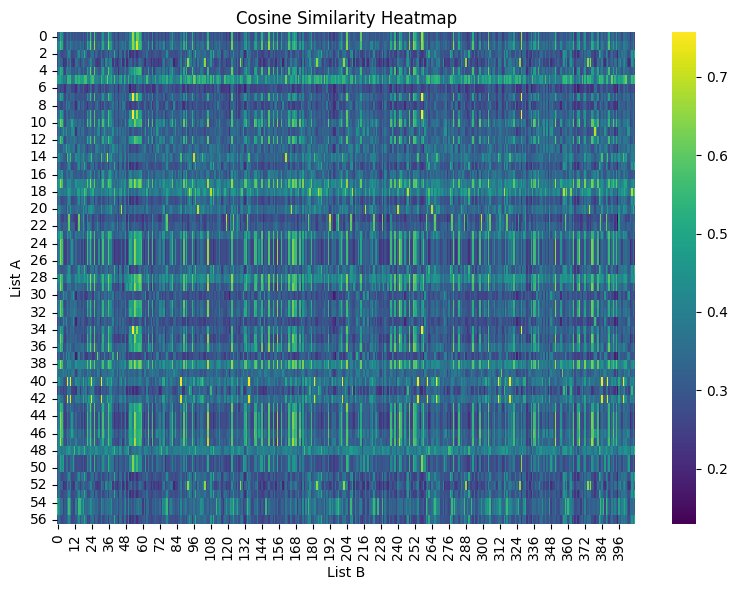

In [43]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


similarity_matrix = scorer.cache['PR Fishers']['GPT 4o']['src']


# Compute cosine similarity matrix (A vs B)
# similarity_matrix = cosine_similarity(list_a, list_b)

# Plot heatmap with values
plt.figure(figsize=(8, 6))
ax = sns.heatmap(similarity_matrix, cmap='viridis', fmt=".2f",)
ax.set_title("Cosine Similarity Heatmap")
plt.xlabel("List B")
plt.ylabel("List A")
plt.tight_layout()
plt.show()


In [28]:
outputs=pd.read_csv('outputs.csv')

In [29]:
outputs.groupby(['method'], as_index=False)['F1'].mean()

,method,F1
0,Basic,0.159029
1,"dual agent (first rag, second full)",0.214531
